In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os
import cv2

from ops import *
from utils import *

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [2]:
tf.__version__

'1.15.0'

In [3]:
DATA_PATH = './celeba10K/' # Path to the dataset with celebA faces
Z_DIM=100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=64*16 # Length of first tensor in generator

IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image

In [4]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [5]:
def generator(z, is_training):
    # Firstly let's reshape input vector into 3-d tensor. 
    z_ = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    
    """
        Your code goes here.
    """
    g_batch_norm_0 = batch_norm(name='g_batch_norm_0')
    h_0_bn = g_batch_norm_0(h_in, is_training)
    h_0_a = lrelu(h_0_bn, name='g_lr_0')
    
    h_1 = deconv2d(h_0_a, output_shape=[BATCH_SIZE, 8, 8, 512], name='g_deconv2d_1')
    g_batch_norm_1 = batch_norm(name='g_batch_norm_1')
    h_1_bn = g_batch_norm_1(h_1, is_training)
    h_1_a = lrelu(h_1_bn, name='g_lr_1')
    h_1_a_dr = tf.nn.dropout(h_1_a, 0.3, name='g_dr_1')
    
    h_2 = deconv2d(h_1_a_dr, output_shape=[BATCH_SIZE, 16, 16, 256], name='g_deconv2d_2')
    g_batch_norm_2 = batch_norm(name='g_batch_norm_2')
    h_2_bn = g_batch_norm_2(h_2, is_training)
    h_2_a = lrelu(h_2_bn, name='g_lr_2')
    h_2_a_dr = tf.nn.dropout(h_2_a, 0.3, name='g_dr_2')
    
    h_3 = deconv2d(h_2_a_dr, output_shape=[BATCH_SIZE, 32, 32, 128], name='g_deconv2d_3')
    g_batch_norm_3 = batch_norm(name='g_batch_norm_3')
    h_3_bn = g_batch_norm_3(h_3, is_training)
    h_3_a = lrelu(h_3_bn, name='g_lr_3')  
    
    h_out = deconv2d(h_3_a, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS],
            name='g_out')

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [6]:
def discriminator(image, is_training, batch_norms=None):
    """
        Your code goes here.
    """
    d_0_conv2d = conv2d(image, output_dim=32, name='d_0_conv2d') 
    d_0_bn = batch_norm(name = 'd_0_norm')
    h_0_bn = d_0_bn(d_0_conv2d, is_training)
    h_0_a = lrelu(h_0_bn, name = 'd_0_lrelu')
    h_0_p = tf.layers.average_pooling2d(h_0_a, pool_size=(2, 2), strides=2, name='d_pool_0')
    
    d_1_conv2d = conv2d(h_0_p, output_dim=64, name='d_1_conv2d')
    d_1_bn = batch_norm(name = 'd_1_norm')
    h_1_bn = d_1_bn(d_1_conv2d, is_training)
    h_1_a = lrelu(h_1_bn, name = 'd_1_lrelu')
    h_1_p = tf.layers.average_pooling2d(h_1_a, pool_size=(2, 2), strides=2, name='d_pool_1')
    
    d_2_conv2d = conv2d(h_1_p, output_dim=128, name='d_2_conv2d') 
    d_2_bn = batch_norm(name = 'd_2_norm')
    h_2_bn = d_2_bn(d_2_conv2d, is_training)
    h_2_a = lrelu(h_2_bn, name = 'd_2_lrelu')
    h_2_p = tf.layers.average_pooling2d(h_2_a, pool_size=(2, 2), strides=2, name='d_pool_2')
    
    d_flat = tf.layers.flatten(h_2_p)
    d_lin = linear(d_flat, 256, 'd_h_linear')
    d_lin_a = lrelu(d_lin, name='d_lr_4')
    
    linear_out = linear(d_lin_a,1,'linear_out')
    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [7]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    
    # If you use batch norms from ops define them here (like batch_norms = [batch_norm(name='d_bn0')])
    # and pass to discriminator function instances.
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.AveragePooling2D instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.


Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [8]:
"""
        You code goes here. Define discriminator and generator losses
"""
d_loss_real = -tf.reduce_mean(tf.log(D_real + 1e-30))

d_loss_fake = -tf.reduce_mean(tf.log(1 - D_fake + 1e-30))

d_loss = d_loss_real + d_loss_fake

g_loss = -tf.reduce_mean(tf.log(D_fake + 1e-30))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [9]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

Load data:

In [10]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))
assert(len(data) > 0), "Length of training data should be more than zero"

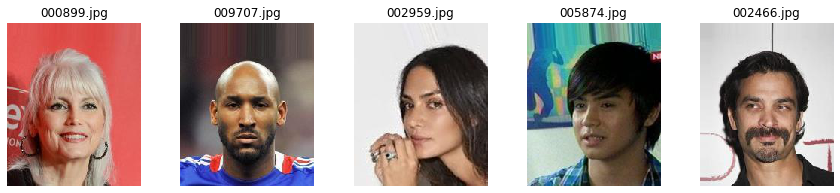

In [11]:
def visualize(data_path, n_cols=5, n_rows=1):
    plt.figure(figsize = (3*n_cols,3*n_rows))
    for n, filename in enumerate(np.random.choice(os.listdir(data_path), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        img = plt.imread(os.path.join(data_path, filename))
        plt.imshow(img)
        plt.title(filename)
    plt.show()
visualize(DATA_PATH)

Functions for training and evaluations.

In [12]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [13]:
def train(sess, load_dir=None, save_frequency=100, sample_frequency=100, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=20, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(0, batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            # Update D network
            sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim,
                    feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples, [MERGE_X, MERGE_X], os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)))
                print("Sample")

In [41]:
with tf.Session() as sess:
    train(sess, save_dir='checkpoint')

Epoch: [ 0] [   0/ 156] time: 7.9453, d_loss: 1.38623428, g_loss: 0.69301295
Epoch: [ 0] [   1/ 156] time: 14.4124, d_loss: 1.38616610, g_loss: 0.69314879
Epoch: [ 0] [   2/ 156] time: 20.9328, d_loss: 1.38600457, g_loss: 0.69346988
Epoch: [ 0] [   3/ 156] time: 27.4755, d_loss: 1.38579416, g_loss: 0.69376534
Epoch: [ 0] [   4/ 156] time: 34.0306, d_loss: 1.38475084, g_loss: 0.69424587
Epoch: [ 0] [   5/ 156] time: 40.5631, d_loss: 1.38171232, g_loss: 0.69486094
Epoch: [ 0] [   6/ 156] time: 47.1192, d_loss: 1.37479734, g_loss: 0.69555771
Epoch: [ 0] [   7/ 156] time: 53.6652, d_loss: 1.36292052, g_loss: 0.69686186
Epoch: [ 0] [   8/ 156] time: 60.2162, d_loss: 1.35343158, g_loss: 0.69373035
Epoch: [ 0] [   9/ 156] time: 66.7301, d_loss: 1.34791470, g_loss: 0.68097508
Epoch: [ 0] [  10/ 156] time: 73.2894, d_loss: 1.35201132, g_loss: 0.66675019
Epoch: [ 0] [  11/ 156] time: 79.8820, d_loss: 1.34584260, g_loss: 0.65694892
Epoch: [ 0] [  12/ 156] time: 86.4730, d_loss: 1.33174551, g_loss

Epoch: [ 0] [ 104/ 156] time: 690.0334, d_loss: 1.44255757, g_loss: 0.68541563
Epoch: [ 0] [ 105/ 156] time: 696.6473, d_loss: 1.41947556, g_loss: 0.68890119
Epoch: [ 0] [ 106/ 156] time: 703.2358, d_loss: 1.39068389, g_loss: 0.70323074
Epoch: [ 0] [ 107/ 156] time: 709.8290, d_loss: 1.34916258, g_loss: 0.73082101
Epoch: [ 0] [ 108/ 156] time: 716.4212, d_loss: 1.39505386, g_loss: 0.71477044
Epoch: [ 0] [ 109/ 156] time: 723.0598, d_loss: 1.36821747, g_loss: 0.73404992
Epoch: [ 0] [ 110/ 156] time: 729.6732, d_loss: 1.39012957, g_loss: 0.71227008
Epoch: [ 0] [ 111/ 156] time: 736.2683, d_loss: 1.40763879, g_loss: 0.70968968
Epoch: [ 0] [ 112/ 156] time: 742.8611, d_loss: 1.40134811, g_loss: 0.71197152
Epoch: [ 0] [ 113/ 156] time: 749.4789, d_loss: 1.42185450, g_loss: 0.70542830
Epoch: [ 0] [ 114/ 156] time: 756.1229, d_loss: 1.40477943, g_loss: 0.71171540
Epoch: [ 0] [ 115/ 156] time: 762.7410, d_loss: 1.41273677, g_loss: 0.71526253
Epoch: [ 0] [ 116/ 156] time: 769.3510, d_loss: 1.40

Epoch: [ 1] [  51/ 156] time: 1371.6259, d_loss: 1.36308742, g_loss: 0.68581033
Epoch: [ 1] [  52/ 156] time: 1378.1619, d_loss: 1.36402583, g_loss: 0.68761474
Epoch: [ 1] [  53/ 156] time: 1384.7041, d_loss: 1.37332857, g_loss: 0.70489275
Epoch: [ 1] [  54/ 156] time: 1391.2571, d_loss: 1.37133300, g_loss: 0.71716088
Epoch: [ 1] [  55/ 156] time: 1397.8504, d_loss: 1.35284531, g_loss: 0.71145225
Epoch: [ 1] [  56/ 156] time: 1404.4304, d_loss: 1.35651124, g_loss: 0.69944197
Epoch: [ 1] [  57/ 156] time: 1411.0065, d_loss: 1.35647297, g_loss: 0.68819827
Epoch: [ 1] [  58/ 156] time: 1417.5761, d_loss: 1.36476755, g_loss: 0.69655842
Epoch: [ 1] [  59/ 156] time: 1424.1409, d_loss: 1.36108589, g_loss: 0.70700085
Epoch: [ 1] [  60/ 156] time: 1430.6902, d_loss: 1.35445452, g_loss: 0.72924209
Epoch: [ 1] [  61/ 156] time: 1437.2443, d_loss: 1.35420835, g_loss: 0.72759664
Epoch: [ 1] [  62/ 156] time: 1443.8268, d_loss: 1.35538673, g_loss: 0.72053653
Epoch: [ 1] [  63/ 156] time: 1450.4001,

Epoch: [ 1] [ 154/ 156] time: 2049.3538, d_loss: 1.37775302, g_loss: 0.70635283
Epoch: [ 1] [ 155/ 156] time: 2055.9756, d_loss: 1.38202929, g_loss: 0.68915379
Epoch: [ 2] [   0/ 156] time: 2062.6046, d_loss: 1.36544228, g_loss: 0.69250083
Epoch: [ 2] [   1/ 156] time: 2069.2271, d_loss: 1.36966348, g_loss: 0.69492388
Epoch: [ 2] [   2/ 156] time: 2075.8534, d_loss: 1.36252677, g_loss: 0.70568073
Epoch: [ 2] [   3/ 156] time: 2082.4793, d_loss: 1.35815501, g_loss: 0.71788692
Epoch: [ 2] [   4/ 156] time: 2089.0730, d_loss: 1.36132812, g_loss: 0.72833204
Epoch: [ 2] [   5/ 156] time: 2095.7003, d_loss: 1.34613180, g_loss: 0.73251653
Epoch: [ 2] [   6/ 156] time: 2102.3171, d_loss: 1.35073364, g_loss: 0.72189939
Epoch: [ 2] [   7/ 156] time: 2108.9369, d_loss: 1.36133385, g_loss: 0.70226991
Epoch: [ 2] [   8/ 156] time: 2115.5621, d_loss: 1.37279344, g_loss: 0.66787499
Epoch: [ 2] [   9/ 156] time: 2122.1705, d_loss: 1.36128354, g_loss: 0.67532480
Epoch: [ 2] [  10/ 156] time: 2128.7817,

Epoch: [ 2] [ 101/ 156] time: 2731.0079, d_loss: 1.33858728, g_loss: 0.73023617
Epoch: [ 2] [ 102/ 156] time: 2737.5750, d_loss: 1.36911571, g_loss: 0.71289027
Epoch: [ 2] [ 103/ 156] time: 2744.1496, d_loss: 1.41313052, g_loss: 0.69334376
Epoch: [ 2] [ 104/ 156] time: 2750.7000, d_loss: 1.40719628, g_loss: 0.73464179
Epoch: [ 2] [ 105/ 156] time: 2757.2620, d_loss: 1.32608259, g_loss: 0.83801836
Epoch: [ 2] [ 106/ 156] time: 2763.8307, d_loss: 1.32807565, g_loss: 0.80533743
Epoch: [ 2] [ 107/ 156] time: 2770.3980, d_loss: 1.35867071, g_loss: 0.73225009
Epoch: [ 2] [ 108/ 156] time: 2776.9445, d_loss: 1.40282440, g_loss: 0.68140161
Epoch: [ 2] [ 109/ 156] time: 2783.4901, d_loss: 1.40863204, g_loss: 0.66679674
Epoch: [ 2] [ 110/ 156] time: 2790.0743, d_loss: 1.43130136, g_loss: 0.66038227
Epoch: [ 2] [ 111/ 156] time: 2796.6378, d_loss: 1.41912889, g_loss: 0.67415679
Epoch: [ 2] [ 112/ 156] time: 2803.2061, d_loss: 1.37290788, g_loss: 0.71968031
Epoch: [ 2] [ 113/ 156] time: 2809.7623,

Epoch: [ 3] [  48/ 156] time: 3408.9117, d_loss: 1.37800479, g_loss: 0.67442024
Epoch: [ 3] [  49/ 156] time: 3415.4979, d_loss: 1.35438907, g_loss: 0.68093759
Epoch: [ 3] [  50/ 156] time: 3422.1144, d_loss: 1.36543369, g_loss: 0.67742276
Epoch: [ 3] [  51/ 156] time: 3428.7270, d_loss: 1.35898352, g_loss: 0.69266158
Epoch: [ 3] [  52/ 156] time: 3435.3532, d_loss: 1.36168981, g_loss: 0.69791055
Epoch: [ 3] [  53/ 156] time: 3441.9942, d_loss: 1.36681795, g_loss: 0.69653934
Epoch: [ 3] [  54/ 156] time: 3448.5895, d_loss: 1.36299515, g_loss: 0.70942211
Epoch: [ 3] [  55/ 156] time: 3455.2083, d_loss: 1.39385509, g_loss: 0.70043194
Epoch: [ 3] [  56/ 156] time: 3461.8121, d_loss: 1.38541269, g_loss: 0.70347869
Epoch: [ 3] [  57/ 156] time: 3468.4335, d_loss: 1.38739407, g_loss: 0.71551275
Epoch: [ 3] [  58/ 156] time: 3475.0555, d_loss: 1.37180996, g_loss: 0.71354413
Epoch: [ 3] [  59/ 156] time: 3481.6742, d_loss: 1.34656525, g_loss: 0.70131910
Epoch: [ 3] [  60/ 156] time: 3488.2882,

Epoch: [ 3] [ 151/ 156] time: 4091.2379, d_loss: 1.37136769, g_loss: 0.69845575
Epoch: [ 3] [ 152/ 156] time: 4097.8315, d_loss: 1.37078142, g_loss: 0.69312739
Epoch: [ 3] [ 153/ 156] time: 4104.4330, d_loss: 1.36684620, g_loss: 0.69042075
Epoch: [ 3] [ 154/ 156] time: 4111.0192, d_loss: 1.37899613, g_loss: 0.69231153
Epoch: [ 3] [ 155/ 156] time: 4117.6134, d_loss: 1.40655851, g_loss: 0.68990064
Epoch: [ 4] [   0/ 156] time: 4124.2025, d_loss: 1.39586210, g_loss: 0.69610316
Epoch: [ 4] [   1/ 156] time: 4130.7790, d_loss: 1.38810897, g_loss: 0.69993484
Epoch: [ 4] [   2/ 156] time: 4137.3591, d_loss: 1.38124406, g_loss: 0.69714284
Epoch: [ 4] [   3/ 156] time: 4143.9381, d_loss: 1.36125445, g_loss: 0.70049369
Epoch: [ 4] [   4/ 156] time: 4150.5441, d_loss: 1.38860977, g_loss: 0.69290698
Epoch: [ 4] [   5/ 156] time: 4157.1185, d_loss: 1.40293801, g_loss: 0.69611096
Epoch: [ 4] [   6/ 156] time: 4163.6970, d_loss: 1.38344598, g_loss: 0.70435512
Epoch: [ 4] [   7/ 156] time: 4170.2722,

Epoch: [ 4] [  98/ 156] time: 4772.2683, d_loss: 1.38072979, g_loss: 0.69663525
Epoch: [ 4] [  99/ 156] time: 4778.8561, d_loss: 1.38400698, g_loss: 0.69324297
Epoch: [ 4] [ 100/ 156] time: 4785.4321, d_loss: 1.38628554, g_loss: 0.67912912
Epoch: [ 4] [ 101/ 156] time: 4791.9955, d_loss: 1.37136209, g_loss: 0.68940210
Epoch: [ 4] [ 102/ 156] time: 4798.5720, d_loss: 1.38275349, g_loss: 0.69759893
Epoch: [ 4] [ 103/ 156] time: 4805.1344, d_loss: 1.39814961, g_loss: 0.66678822
Epoch: [ 4] [ 104/ 156] time: 4811.7405, d_loss: 1.38519502, g_loss: 0.69540465
Epoch: [ 4] [ 105/ 156] time: 4818.3338, d_loss: 1.35956347, g_loss: 0.71269953
Epoch: [ 4] [ 106/ 156] time: 4824.9255, d_loss: 1.35731173, g_loss: 0.71076614
Epoch: [ 4] [ 107/ 156] time: 4831.4987, d_loss: 1.34667146, g_loss: 0.72957385
Epoch: [ 4] [ 108/ 156] time: 4838.0838, d_loss: 1.32643604, g_loss: 0.73696297
Epoch: [ 4] [ 109/ 156] time: 4844.6402, d_loss: 1.34328723, g_loss: 0.71850574
Epoch: [ 4] [ 110/ 156] time: 4851.2179,

Epoch: [ 5] [  45/ 156] time: 5451.6359, d_loss: 1.32024491, g_loss: 0.73288709
Epoch: [ 5] [  46/ 156] time: 5458.2142, d_loss: 1.34741437, g_loss: 0.71065807
Epoch: [ 5] [  47/ 156] time: 5464.7592, d_loss: 1.32911742, g_loss: 0.70420241
Epoch: [ 5] [  48/ 156] time: 5471.3760, d_loss: 1.34166932, g_loss: 0.68572992
Epoch: [ 5] [  49/ 156] time: 5477.9614, d_loss: 1.32068086, g_loss: 0.70445251
Epoch: [ 5] [  50/ 156] time: 5484.5519, d_loss: 1.34105301, g_loss: 0.68671107
Epoch: [ 5] [  51/ 156] time: 5491.1302, d_loss: 1.35588312, g_loss: 0.69499469
Epoch: [ 5] [  52/ 156] time: 5497.6806, d_loss: 1.32819045, g_loss: 0.69450521
Epoch: [ 5] [  53/ 156] time: 5504.2266, d_loss: 1.35442686, g_loss: 0.70907444
Epoch: [ 5] [  54/ 156] time: 5510.7707, d_loss: 1.33917630, g_loss: 0.74237454
Epoch: [ 5] [  55/ 156] time: 5517.3192, d_loss: 1.33917129, g_loss: 0.72786570
Epoch: [ 5] [  56/ 156] time: 5523.9065, d_loss: 1.36030996, g_loss: 0.71619958
Epoch: [ 5] [  57/ 156] time: 5530.4918,

Epoch: [ 5] [ 148/ 156] time: 6130.5343, d_loss: 1.38017499, g_loss: 0.68185794
Epoch: [ 5] [ 149/ 156] time: 6137.1071, d_loss: 1.37597072, g_loss: 0.69727921
Epoch: [ 5] [ 150/ 156] time: 6143.6747, d_loss: 1.39475930, g_loss: 0.70812553
Epoch: [ 5] [ 151/ 156] time: 6150.2416, d_loss: 1.36957312, g_loss: 0.72543025
Epoch: [ 5] [ 152/ 156] time: 6156.8227, d_loss: 1.37857103, g_loss: 0.71103394
Epoch: [ 5] [ 153/ 156] time: 6163.4115, d_loss: 1.39685011, g_loss: 0.66488284
Epoch: [ 5] [ 154/ 156] time: 6169.9879, d_loss: 1.43162274, g_loss: 0.66820496
Epoch: [ 5] [ 155/ 156] time: 6176.5632, d_loss: 1.39255357, g_loss: 0.67850679
Epoch: [ 6] [   0/ 156] time: 6183.1416, d_loss: 1.37022066, g_loss: 0.72170937
Epoch: [ 6] [   1/ 156] time: 6189.7104, d_loss: 1.35071981, g_loss: 0.74280572
Epoch: [ 6] [   2/ 156] time: 6196.3243, d_loss: 1.34134018, g_loss: 0.73830342
Epoch: [ 6] [   3/ 156] time: 6202.8962, d_loss: 1.37803924, g_loss: 0.71608508
Epoch: [ 6] [   4/ 156] time: 6209.4697,

Epoch: [ 6] [  95/ 156] time: 6811.0844, d_loss: 1.32522857, g_loss: 0.73229212
Epoch: [ 6] [  96/ 156] time: 6817.7120, d_loss: 1.36358047, g_loss: 0.71174848
Epoch: [ 6] [  97/ 156] time: 6824.3270, d_loss: 1.36602402, g_loss: 0.70576876
Epoch: [ 6] [  98/ 156] time: 6830.9388, d_loss: 1.34601712, g_loss: 0.70999324
Epoch: [ 6] [  99/ 156] time: 6837.5568, d_loss: 1.32169390, g_loss: 0.74943441
Epoch: [ 6] [ 100/ 156] time: 6844.1750, d_loss: 1.36913681, g_loss: 0.69746077
Epoch: [ 6] [ 101/ 156] time: 6850.8067, d_loss: 1.31922448, g_loss: 0.70992911
Epoch: [ 6] [ 102/ 156] time: 6857.4380, d_loss: 1.31726909, g_loss: 0.74072719
Epoch: [ 6] [ 103/ 156] time: 6864.0665, d_loss: 1.32149506, g_loss: 0.71337759
Epoch: [ 6] [ 104/ 156] time: 6870.6827, d_loss: 1.33309555, g_loss: 0.70983839
Epoch: [ 6] [ 105/ 156] time: 6877.3201, d_loss: 1.33325183, g_loss: 0.70055604
Epoch: [ 6] [ 106/ 156] time: 6883.9491, d_loss: 1.32250583, g_loss: 0.68548834
Epoch: [ 6] [ 107/ 156] time: 6890.5874,

Epoch: [ 7] [  42/ 156] time: 7492.0908, d_loss: 1.32599866, g_loss: 0.73204172
Epoch: [ 7] [  43/ 156] time: 7498.6425, d_loss: 1.34889770, g_loss: 0.74716449
Epoch: [ 7] [  44/ 156] time: 7505.1991, d_loss: 1.38568449, g_loss: 0.73213947
Epoch: [ 7] [  45/ 156] time: 7511.7626, d_loss: 1.37370396, g_loss: 0.71711767
Epoch: [ 7] [  46/ 156] time: 7518.3196, d_loss: 1.37379515, g_loss: 0.68272340
Epoch: [ 7] [  47/ 156] time: 7524.8891, d_loss: 1.34262204, g_loss: 0.71323568
Epoch: [ 7] [  48/ 156] time: 7531.4603, d_loss: 1.36672926, g_loss: 0.65806788
Epoch: [ 7] [  49/ 156] time: 7538.0266, d_loss: 1.31902242, g_loss: 0.72404194
Epoch: [ 7] [  50/ 156] time: 7544.5935, d_loss: 1.32828319, g_loss: 0.71675074
Epoch: [ 7] [  51/ 156] time: 7551.1469, d_loss: 1.37201238, g_loss: 0.68031812
Epoch: [ 7] [  52/ 156] time: 7557.7356, d_loss: 1.36663842, g_loss: 0.66384780
Epoch: [ 7] [  53/ 156] time: 7564.2982, d_loss: 1.36362886, g_loss: 0.68089515
Epoch: [ 7] [  54/ 156] time: 7570.8616,

Epoch: [ 7] [ 145/ 156] time: 8172.0691, d_loss: 1.35781324, g_loss: 0.86477989
Epoch: [ 7] [ 146/ 156] time: 8178.6719, d_loss: 1.35387993, g_loss: 0.80188495
Epoch: [ 7] [ 147/ 156] time: 8185.2355, d_loss: 1.42879701, g_loss: 0.70711303
Epoch: [ 7] [ 148/ 156] time: 8191.8124, d_loss: 1.34532142, g_loss: 0.74640346
Epoch: [ 7] [ 149/ 156] time: 8198.3956, d_loss: 1.34959984, g_loss: 0.76488662
Epoch: [ 7] [ 150/ 156] time: 8204.9620, d_loss: 1.35115409, g_loss: 0.73836553
Epoch: [ 7] [ 151/ 156] time: 8211.5474, d_loss: 1.35115254, g_loss: 0.74472696
Epoch: [ 7] [ 152/ 156] time: 8218.1238, d_loss: 1.28288007, g_loss: 0.75472897
Epoch: [ 7] [ 153/ 156] time: 8224.6925, d_loss: 1.31056213, g_loss: 0.71309137
Epoch: [ 7] [ 154/ 156] time: 8231.2665, d_loss: 1.37928045, g_loss: 0.67501605
Epoch: [ 7] [ 155/ 156] time: 8237.8908, d_loss: 1.36632037, g_loss: 0.63533866
Epoch: [ 8] [   0/ 156] time: 8244.5136, d_loss: 1.35776091, g_loss: 0.66478080
Epoch: [ 8] [   1/ 156] time: 8251.1386,

Epoch: [ 8] [  92/ 156] time: 8852.4762, d_loss: 1.39574432, g_loss: 0.73041964
Epoch: [ 8] [  93/ 156] time: 8859.0498, d_loss: 1.37090731, g_loss: 0.74286681
Epoch: [ 8] [  94/ 156] time: 8865.6217, d_loss: 1.33213329, g_loss: 0.80374444
Epoch: [ 8] [  95/ 156] time: 8872.1936, d_loss: 1.33032191, g_loss: 0.75942773
Epoch: [ 8] [  96/ 156] time: 8878.7539, d_loss: 1.35584283, g_loss: 0.68439907
Epoch: [ 8] [  97/ 156] time: 8885.3484, d_loss: 1.33097720, g_loss: 0.70235324
Epoch: [ 8] [  98/ 156] time: 8891.9436, d_loss: 1.29592395, g_loss: 0.72864044
Epoch: [ 8] [  99/ 156] time: 8898.5270, d_loss: 1.36988127, g_loss: 0.75772417
Epoch: [ 8] [ 100/ 156] time: 8905.0915, d_loss: 1.34121740, g_loss: 0.74306983
Epoch: [ 8] [ 101/ 156] time: 8911.6852, d_loss: 1.32117033, g_loss: 0.77476567
Epoch: [ 8] [ 102/ 156] time: 8918.2734, d_loss: 1.28433919, g_loss: 0.83330989
Epoch: [ 8] [ 103/ 156] time: 8924.8532, d_loss: 1.28276086, g_loss: 0.79052842
Epoch: [ 8] [ 104/ 156] time: 8931.4341,

Epoch: [ 9] [  39/ 156] time: 9532.9349, d_loss: 1.31299925, g_loss: 0.71034467
Epoch: [ 9] [  40/ 156] time: 9539.5612, d_loss: 1.31019807, g_loss: 0.73428750
Epoch: [ 9] [  41/ 156] time: 9546.1931, d_loss: 1.32566977, g_loss: 0.77661693
Epoch: [ 9] [  42/ 156] time: 9552.8143, d_loss: 1.29454601, g_loss: 0.77845061
Epoch: [ 9] [  43/ 156] time: 9559.4483, d_loss: 1.29221201, g_loss: 0.74311662
Epoch: [ 9] [  44/ 156] time: 9566.0758, d_loss: 1.30266392, g_loss: 0.69041800
Epoch: [ 9] [  45/ 156] time: 9572.6999, d_loss: 1.28478038, g_loss: 0.73047340
Epoch: [ 9] [  46/ 156] time: 9579.3138, d_loss: 1.29906845, g_loss: 0.73089790
Epoch: [ 9] [  47/ 156] time: 9585.9135, d_loss: 1.31809211, g_loss: 0.68954265
Epoch: [ 9] [  48/ 156] time: 9592.5381, d_loss: 1.31108069, g_loss: 0.68916625
Epoch: [ 9] [  49/ 156] time: 9599.1605, d_loss: 1.31922448, g_loss: 0.70281774
Epoch: [ 9] [  50/ 156] time: 9605.8048, d_loss: 1.31658685, g_loss: 0.70161843
Epoch: [ 9] [  51/ 156] time: 9612.4189,

Epoch: [ 9] [ 141/ 156] time: 10206.6790, d_loss: 1.30243480, g_loss: 0.82033801
Epoch: [ 9] [ 142/ 156] time: 10213.2303, d_loss: 1.29003000, g_loss: 0.76525074
Epoch: [ 9] [ 143/ 156] time: 10219.7724, d_loss: 1.35856998, g_loss: 0.74814713
Epoch: [ 9] [ 144/ 156] time: 10226.3546, d_loss: 1.32164574, g_loss: 0.76634854
Epoch: [ 9] [ 145/ 156] time: 10232.9301, d_loss: 1.28158689, g_loss: 0.80558801
Epoch: [ 9] [ 146/ 156] time: 10239.5385, d_loss: 1.30400300, g_loss: 0.78326046
Epoch: [ 9] [ 147/ 156] time: 10246.1061, d_loss: 1.33744264, g_loss: 0.75602841
Epoch: [ 9] [ 148/ 156] time: 10252.6782, d_loss: 1.34716368, g_loss: 0.77809620
Epoch: [ 9] [ 149/ 156] time: 10259.2573, d_loss: 1.30567896, g_loss: 0.75793576
Epoch: [ 9] [ 150/ 156] time: 10265.8519, d_loss: 1.31298494, g_loss: 0.72981209
Epoch: [ 9] [ 151/ 156] time: 10272.4219, d_loss: 1.30188370, g_loss: 0.74581307
Epoch: [ 9] [ 152/ 156] time: 10278.9840, d_loss: 1.27283311, g_loss: 0.71472120
Epoch: [ 9] [ 153/ 156] time

Epoch: [10] [  86/ 156] time: 10873.7048, d_loss: 1.23194432, g_loss: 0.77204680
Epoch: [10] [  87/ 156] time: 10880.3246, d_loss: 1.29480290, g_loss: 0.74335665
Epoch: [10] [  88/ 156] time: 10886.9448, d_loss: 1.31977904, g_loss: 0.65516549
Epoch: [10] [  89/ 156] time: 10893.5652, d_loss: 1.33646142, g_loss: 0.67213416
Epoch: [10] [  90/ 156] time: 10900.2012, d_loss: 1.32552648, g_loss: 0.69047731
Epoch: [10] [  91/ 156] time: 10906.8198, d_loss: 1.29383373, g_loss: 0.75978088
Epoch: [10] [  92/ 156] time: 10913.4418, d_loss: 1.31217384, g_loss: 0.76867545
Epoch: [10] [  93/ 156] time: 10920.0607, d_loss: 1.31265211, g_loss: 0.79264814
Epoch: [10] [  94/ 156] time: 10926.6789, d_loss: 1.30805278, g_loss: 0.75078756
Epoch: [10] [  95/ 156] time: 10933.3066, d_loss: 1.33264709, g_loss: 0.69792759
Epoch: [10] [  96/ 156] time: 10939.9528, d_loss: 1.25983477, g_loss: 0.69994420
Epoch: [10] [  97/ 156] time: 10946.5818, d_loss: 1.26839995, g_loss: 0.69933009
Epoch: [10] [  98/ 156] time

Epoch: [11] [  31/ 156] time: 11539.8409, d_loss: 1.36629152, g_loss: 0.66443110
Epoch: [11] [  32/ 156] time: 11546.3839, d_loss: 1.30739439, g_loss: 0.74637705
Epoch: [11] [  33/ 156] time: 11552.9521, d_loss: 1.28746426, g_loss: 0.72605252
Epoch: [11] [  34/ 156] time: 11559.4864, d_loss: 1.32387829, g_loss: 0.68411005
Epoch: [11] [  35/ 156] time: 11566.0440, d_loss: 1.34697533, g_loss: 0.70724690
Epoch: [11] [  36/ 156] time: 11572.5849, d_loss: 1.39748657, g_loss: 0.68911189
Epoch: [11] [  37/ 156] time: 11579.1247, d_loss: 1.30902743, g_loss: 0.77285558
Epoch: [11] [  38/ 156] time: 11585.6473, d_loss: 1.27084851, g_loss: 0.76801038
Epoch: [11] [  39/ 156] time: 11592.2147, d_loss: 1.30579996, g_loss: 0.76606834
Epoch: [11] [  40/ 156] time: 11598.7593, d_loss: 1.28729975, g_loss: 0.74765086
Epoch: [11] [  41/ 156] time: 11605.3230, d_loss: 1.34871709, g_loss: 0.70156169
Epoch: [11] [  42/ 156] time: 11611.8792, d_loss: 1.27413154, g_loss: 0.73915815
Epoch: [11] [  43/ 156] time

Epoch: [11] [ 132/ 156] time: 12205.8519, d_loss: 1.25388575, g_loss: 0.81304729
Epoch: [11] [ 133/ 156] time: 12212.4571, d_loss: 1.30683446, g_loss: 0.82226348
Epoch: [11] [ 134/ 156] time: 12219.0666, d_loss: 1.33474422, g_loss: 0.66958785
Epoch: [11] [ 135/ 156] time: 12225.6804, d_loss: 1.39798105, g_loss: 0.66015053
Epoch: [11] [ 136/ 156] time: 12232.2871, d_loss: 1.43146515, g_loss: 0.60452282
Epoch: [11] [ 137/ 156] time: 12238.9078, d_loss: 1.34825063, g_loss: 0.69617414
Epoch: [11] [ 138/ 156] time: 12245.5389, d_loss: 1.33134532, g_loss: 0.70652246
Epoch: [11] [ 139/ 156] time: 12252.1743, d_loss: 1.35071349, g_loss: 0.61911833
Epoch: [11] [ 140/ 156] time: 12258.8146, d_loss: 1.34219480, g_loss: 0.67933142
Epoch: [11] [ 141/ 156] time: 12265.4468, d_loss: 1.30163479, g_loss: 0.65306628
Epoch: [11] [ 142/ 156] time: 12272.0787, d_loss: 1.32005644, g_loss: 0.77156365
Epoch: [11] [ 143/ 156] time: 12278.6970, d_loss: 1.34443069, g_loss: 0.77597320
Epoch: [11] [ 144/ 156] time

Epoch: [12] [  77/ 156] time: 12872.2729, d_loss: 1.26768827, g_loss: 0.74223119
Epoch: [12] [  78/ 156] time: 12878.8468, d_loss: 1.24774015, g_loss: 0.76144892
Epoch: [12] [  79/ 156] time: 12885.4446, d_loss: 1.28281999, g_loss: 0.70281106
Epoch: [12] [  80/ 156] time: 12891.9902, d_loss: 1.24271822, g_loss: 0.72084439
Epoch: [12] [  81/ 156] time: 12898.5576, d_loss: 1.22042000, g_loss: 0.77805650
Epoch: [12] [  82/ 156] time: 12905.1187, d_loss: 1.22519922, g_loss: 0.72604477
Epoch: [12] [  83/ 156] time: 12911.6838, d_loss: 1.25584984, g_loss: 0.73875487
Epoch: [12] [  84/ 156] time: 12918.2500, d_loss: 1.21175349, g_loss: 0.81782424
Epoch: [12] [  85/ 156] time: 12924.8129, d_loss: 1.21995759, g_loss: 0.82157367
Epoch: [12] [  86/ 156] time: 12931.3718, d_loss: 1.24906349, g_loss: 0.72214335
Epoch: [12] [  87/ 156] time: 12937.9196, d_loss: 1.30721617, g_loss: 0.77832538
Epoch: [12] [  88/ 156] time: 12944.4746, d_loss: 1.26926863, g_loss: 0.81277180
Epoch: [12] [  89/ 156] time

Epoch: [13] [  22/ 156] time: 13538.7124, d_loss: 1.22841418, g_loss: 0.75556654
Epoch: [13] [  23/ 156] time: 13545.3369, d_loss: 1.19286108, g_loss: 0.73161715
Epoch: [13] [  24/ 156] time: 13551.9332, d_loss: 1.19969118, g_loss: 0.74938262
Epoch: [13] [  25/ 156] time: 13558.5783, d_loss: 1.19564199, g_loss: 0.77290809
Epoch: [13] [  26/ 156] time: 13565.2221, d_loss: 1.25167370, g_loss: 0.75065368
Epoch: [13] [  27/ 156] time: 13571.8359, d_loss: 1.24783969, g_loss: 0.93259567
Epoch: [13] [  28/ 156] time: 13578.4651, d_loss: 1.17655349, g_loss: 1.00481820
Epoch: [13] [  29/ 156] time: 13585.0910, d_loss: 1.22330034, g_loss: 0.89104396
Epoch: [13] [  30/ 156] time: 13591.7156, d_loss: 1.28683376, g_loss: 0.78325951
Epoch: [13] [  31/ 156] time: 13598.3364, d_loss: 1.26076055, g_loss: 0.76539844
Epoch: [13] [  32/ 156] time: 13604.9622, d_loss: 1.31152201, g_loss: 0.68202704
Epoch: [13] [  33/ 156] time: 13611.5735, d_loss: 1.25066876, g_loss: 0.67689943
Epoch: [13] [  34/ 156] time

Epoch: [13] [ 123/ 156] time: 14205.5322, d_loss: 1.31923306, g_loss: 0.78219342
Epoch: [13] [ 124/ 156] time: 14212.0891, d_loss: 1.27155900, g_loss: 0.84468019
Epoch: [13] [ 125/ 156] time: 14218.6558, d_loss: 1.30323577, g_loss: 0.81856692
Epoch: [13] [ 126/ 156] time: 14225.2250, d_loss: 1.25124383, g_loss: 0.88002628
Epoch: [13] [ 127/ 156] time: 14231.7940, d_loss: 1.24999619, g_loss: 0.80349660
Epoch: [13] [ 128/ 156] time: 14238.3615, d_loss: 1.28714299, g_loss: 0.77427346
Epoch: [13] [ 129/ 156] time: 14244.9184, d_loss: 1.30433190, g_loss: 0.74235380
Epoch: [13] [ 130/ 156] time: 14251.4834, d_loss: 1.30691850, g_loss: 0.72016418
Epoch: [13] [ 131/ 156] time: 14258.0592, d_loss: 1.29680252, g_loss: 0.76580900
Epoch: [13] [ 132/ 156] time: 14264.6411, d_loss: 1.28065014, g_loss: 0.71950817
Epoch: [13] [ 133/ 156] time: 14271.2095, d_loss: 1.32519782, g_loss: 0.75196731
Epoch: [13] [ 134/ 156] time: 14277.7777, d_loss: 1.27305508, g_loss: 0.82366949
Epoch: [13] [ 135/ 156] time

Epoch: [14] [  68/ 156] time: 14872.0639, d_loss: 1.29005098, g_loss: 0.68366015
Epoch: [14] [  69/ 156] time: 14878.6890, d_loss: 1.22878337, g_loss: 0.73450470
Epoch: [14] [  70/ 156] time: 14885.3102, d_loss: 1.26059484, g_loss: 0.79902852
Epoch: [14] [  71/ 156] time: 14891.9252, d_loss: 1.18119621, g_loss: 0.82106483
Epoch: [14] [  72/ 156] time: 14898.5285, d_loss: 1.23938632, g_loss: 0.80108303
Epoch: [14] [  73/ 156] time: 14905.1428, d_loss: 1.22542953, g_loss: 0.73868054
Epoch: [14] [  74/ 156] time: 14911.7792, d_loss: 1.20693970, g_loss: 0.80926108
Epoch: [14] [  75/ 156] time: 14918.3650, d_loss: 1.28825688, g_loss: 0.87821168
Epoch: [14] [  76/ 156] time: 14924.9658, d_loss: 1.28363156, g_loss: 0.79076421
Epoch: [14] [  77/ 156] time: 14931.5846, d_loss: 1.30752516, g_loss: 0.78856844
Epoch: [14] [  78/ 156] time: 14938.1985, d_loss: 1.28043509, g_loss: 0.61048681
Epoch: [14] [  79/ 156] time: 14944.8181, d_loss: 1.26208055, g_loss: 0.69849163
Epoch: [14] [  80/ 156] time

Epoch: [15] [  13/ 156] time: 15538.9033, d_loss: 1.28689480, g_loss: 0.79172307
Epoch: [15] [  14/ 156] time: 15545.4964, d_loss: 1.23158062, g_loss: 0.82766545
Epoch: [15] [  15/ 156] time: 15552.0969, d_loss: 1.21694446, g_loss: 0.72893238
Epoch: [15] [  16/ 156] time: 15558.7036, d_loss: 1.20481193, g_loss: 0.72170138
Epoch: [15] [  17/ 156] time: 15565.3030, d_loss: 1.31547260, g_loss: 0.63933688
Epoch: [15] [  18/ 156] time: 15571.9025, d_loss: 1.23283517, g_loss: 0.78071034
Epoch: [15] [  19/ 156] time: 15578.5112, d_loss: 1.26804066, g_loss: 0.98395222
Epoch: [15] [  20/ 156] time: 15585.1242, d_loss: 1.18073249, g_loss: 0.93613052
Epoch: [15] [  21/ 156] time: 15591.7362, d_loss: 1.18926275, g_loss: 0.77904367
Epoch: [15] [  22/ 156] time: 15598.3382, d_loss: 1.26005340, g_loss: 0.84283525
Epoch: [15] [  23/ 156] time: 15604.9563, d_loss: 1.22068501, g_loss: 0.71569228
Epoch: [15] [  24/ 156] time: 15611.5573, d_loss: 1.25398505, g_loss: 0.73919946
Epoch: [15] [  25/ 156] time

Epoch: [15] [ 114/ 156] time: 16207.3862, d_loss: 1.28206170, g_loss: 0.86276507
Epoch: [15] [ 115/ 156] time: 16214.0097, d_loss: 1.29640555, g_loss: 0.84962970
Epoch: [15] [ 116/ 156] time: 16220.6348, d_loss: 1.23651862, g_loss: 0.92191172
Epoch: [15] [ 117/ 156] time: 16227.2608, d_loss: 1.26549053, g_loss: 0.98240507
Epoch: [15] [ 118/ 156] time: 16233.8773, d_loss: 1.19086647, g_loss: 0.92238462
Epoch: [15] [ 119/ 156] time: 16240.5110, d_loss: 1.27214694, g_loss: 0.76128632
Epoch: [15] [ 120/ 156] time: 16247.1480, d_loss: 1.27889776, g_loss: 0.75660050
Epoch: [15] [ 121/ 156] time: 16253.7653, d_loss: 1.21026850, g_loss: 0.81154323
Epoch: [15] [ 122/ 156] time: 16260.3817, d_loss: 1.25853777, g_loss: 0.74714941
Epoch: [15] [ 123/ 156] time: 16266.9927, d_loss: 1.27334642, g_loss: 0.68315572
Epoch: [15] [ 124/ 156] time: 16273.6021, d_loss: 1.28063953, g_loss: 0.89177036
Epoch: [15] [ 125/ 156] time: 16280.2184, d_loss: 1.28100681, g_loss: 0.80678701
Epoch: [15] [ 126/ 156] time

Epoch: [16] [  59/ 156] time: 16876.0707, d_loss: 1.28204346, g_loss: 0.91541457
Epoch: [16] [  60/ 156] time: 16882.7086, d_loss: 1.23684728, g_loss: 0.76964188
Epoch: [16] [  61/ 156] time: 16889.3348, d_loss: 1.19276178, g_loss: 0.75497770
Epoch: [16] [  62/ 156] time: 16895.9520, d_loss: 1.21485710, g_loss: 0.85532022
Epoch: [16] [  63/ 156] time: 16902.6021, d_loss: 1.22480965, g_loss: 0.91565728
Epoch: [16] [  64/ 156] time: 16909.2342, d_loss: 1.20796883, g_loss: 0.94386500
Epoch: [16] [  65/ 156] time: 16915.8797, d_loss: 1.26867557, g_loss: 0.78182876
Epoch: [16] [  66/ 156] time: 16922.5019, d_loss: 1.19525790, g_loss: 0.83176547
Epoch: [16] [  67/ 156] time: 16929.1325, d_loss: 1.26049876, g_loss: 0.67221600
Epoch: [16] [  68/ 156] time: 16935.7764, d_loss: 1.26368403, g_loss: 0.71626770
Epoch: [16] [  69/ 156] time: 16942.3906, d_loss: 1.22918844, g_loss: 0.75516963
Epoch: [16] [  70/ 156] time: 16948.9947, d_loss: 1.22711277, g_loss: 0.90051407
Epoch: [16] [  71/ 156] time

Epoch: [17] [   4/ 156] time: 17544.1632, d_loss: 1.21735609, g_loss: 0.78528130
Epoch: [17] [   5/ 156] time: 17550.7423, d_loss: 1.17816031, g_loss: 0.90417534
Epoch: [17] [   6/ 156] time: 17557.3267, d_loss: 1.25503552, g_loss: 0.88774437
Epoch: [17] [   7/ 156] time: 17563.9069, d_loss: 1.28280544, g_loss: 0.88831055
Epoch: [17] [   8/ 156] time: 17570.4891, d_loss: 1.28397918, g_loss: 0.95274663
Epoch: [17] [   9/ 156] time: 17577.0570, d_loss: 1.18904781, g_loss: 0.98975289
Epoch: [17] [  10/ 156] time: 17583.6378, d_loss: 1.15815556, g_loss: 0.89335084
Epoch: [17] [  11/ 156] time: 17590.2107, d_loss: 1.15202093, g_loss: 0.82079995
Epoch: [17] [  12/ 156] time: 17596.7762, d_loss: 1.19354880, g_loss: 0.80065346
Epoch: [17] [  13/ 156] time: 17603.3441, d_loss: 1.25217104, g_loss: 0.80087709
Epoch: [17] [  14/ 156] time: 17609.9439, d_loss: 1.26544666, g_loss: 0.72933006
Epoch: [17] [  15/ 156] time: 17616.5390, d_loss: 1.20331955, g_loss: 0.73416555
Epoch: [17] [  16/ 156] time

Epoch: [17] [ 105/ 156] time: 18211.9990, d_loss: 1.28220570, g_loss: 0.80593854
Epoch: [17] [ 106/ 156] time: 18218.6219, d_loss: 1.18010736, g_loss: 0.72399032
Epoch: [17] [ 107/ 156] time: 18225.2493, d_loss: 1.19346035, g_loss: 0.70875472
Epoch: [17] [ 108/ 156] time: 18231.8700, d_loss: 1.11694551, g_loss: 0.74830723
Epoch: [17] [ 109/ 156] time: 18238.5027, d_loss: 1.17291999, g_loss: 0.76818216
Epoch: [17] [ 110/ 156] time: 18245.1192, d_loss: 1.17761707, g_loss: 0.79222035
Epoch: [17] [ 111/ 156] time: 18251.7256, d_loss: 1.20274878, g_loss: 0.80628240
Epoch: [17] [ 112/ 156] time: 18258.3269, d_loss: 1.12263703, g_loss: 0.93758345
Epoch: [17] [ 113/ 156] time: 18264.9363, d_loss: 1.18783331, g_loss: 0.86928988
Epoch: [17] [ 114/ 156] time: 18271.5476, d_loss: 1.22659445, g_loss: 0.92931604
Epoch: [17] [ 115/ 156] time: 18278.1635, d_loss: 1.22471178, g_loss: 0.99164188
Epoch: [17] [ 116/ 156] time: 18284.7578, d_loss: 1.19812453, g_loss: 1.01281774
Epoch: [17] [ 117/ 156] time

Epoch: [18] [  50/ 156] time: 18879.1965, d_loss: 1.14487839, g_loss: 0.81403226
Epoch: [18] [  51/ 156] time: 18885.7640, d_loss: 1.14610648, g_loss: 0.80901694
Epoch: [18] [  52/ 156] time: 18892.3253, d_loss: 1.15531063, g_loss: 0.88207835
Epoch: [18] [  53/ 156] time: 18898.8886, d_loss: 1.12985849, g_loss: 0.87296903
Epoch: [18] [  54/ 156] time: 18905.4610, d_loss: 1.21121490, g_loss: 0.88647532
Epoch: [18] [  55/ 156] time: 18912.0238, d_loss: 1.28414679, g_loss: 1.04812169
Epoch: [18] [  56/ 156] time: 18918.6045, d_loss: 1.19460940, g_loss: 0.85649139
Epoch: [18] [  57/ 156] time: 18925.1757, d_loss: 1.22455037, g_loss: 0.82101709
Epoch: [18] [  58/ 156] time: 18931.7373, d_loss: 1.26765418, g_loss: 0.87088150
Epoch: [18] [  59/ 156] time: 18938.3093, d_loss: 1.22923291, g_loss: 0.95777678
Epoch: [18] [  60/ 156] time: 18944.8880, d_loss: 1.17807174, g_loss: 0.77224797
Epoch: [18] [  61/ 156] time: 18951.4657, d_loss: 1.20862544, g_loss: 0.74663132
Epoch: [18] [  62/ 156] time

Epoch: [18] [ 151/ 156] time: 19547.1763, d_loss: 1.17862344, g_loss: 0.81187016
Epoch: [18] [ 152/ 156] time: 19553.8022, d_loss: 1.16384923, g_loss: 0.79536051
Epoch: [18] [ 153/ 156] time: 19560.4211, d_loss: 1.21909380, g_loss: 0.70240951
Epoch: [18] [ 154/ 156] time: 19567.0327, d_loss: 1.17988241, g_loss: 0.93409628
Epoch: [18] [ 155/ 156] time: 19573.6562, d_loss: 1.17505813, g_loss: 0.90307540
Epoch: [19] [   0/ 156] time: 19580.2917, d_loss: 1.15118730, g_loss: 0.80467749
Epoch: [19] [   1/ 156] time: 19586.9072, d_loss: 1.30829537, g_loss: 0.61965024
Epoch: [19] [   2/ 156] time: 19593.5183, d_loss: 1.17162013, g_loss: 0.77128124
Epoch: [19] [   3/ 156] time: 19600.1242, d_loss: 1.25895011, g_loss: 0.80325794
Epoch: [19] [   4/ 156] time: 19606.7955, d_loss: 1.30284727, g_loss: 0.79597878
Epoch: [19] [   5/ 156] time: 19613.4298, d_loss: 1.17291152, g_loss: 0.90172863
Epoch: [19] [   6/ 156] time: 19620.0590, d_loss: 1.20596933, g_loss: 0.96585119
Epoch: [19] [   7/ 156] time

Epoch: [19] [  96/ 156] time: 20214.6284, d_loss: 1.11872625, g_loss: 0.82139850
Epoch: [19] [  97/ 156] time: 20221.1921, d_loss: 1.12095785, g_loss: 0.86712670
Epoch: [19] [  98/ 156] time: 20227.7608, d_loss: 1.17022562, g_loss: 0.78485537
Epoch: [19] [  99/ 156] time: 20234.3285, d_loss: 1.26897526, g_loss: 0.83590627
Epoch: [19] [ 100/ 156] time: 20240.9147, d_loss: 1.22716045, g_loss: 0.90668362
Epoch: [19] [ 101/ 156] time: 20247.4971, d_loss: 1.15101540, g_loss: 0.84858328
Epoch: [19] [ 102/ 156] time: 20254.0705, d_loss: 1.21626258, g_loss: 0.69345725
Epoch: [19] [ 103/ 156] time: 20260.6336, d_loss: 1.17786217, g_loss: 0.68293208
Epoch: [19] [ 104/ 156] time: 20267.2064, d_loss: 1.13656521, g_loss: 0.78824973
Epoch: [19] [ 105/ 156] time: 20273.7840, d_loss: 1.16467953, g_loss: 0.78681016
Epoch: [19] [ 106/ 156] time: 20280.3610, d_loss: 1.18292475, g_loss: 0.84341031
Epoch: [19] [ 107/ 156] time: 20286.9347, d_loss: 1.17675567, g_loss: 0.83975458
Epoch: [19] [ 108/ 156] time

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

In [14]:
def visualize_samples(data, n_cols=5, n_rows=2):
    """Visualize samples."""
    plt.figure(figsize = (n_cols*3,n_rows*3))
    for i in range(n_cols * n_rows):
        plt.subplot(n_rows,n_cols,i+1)
        plt.axis('off')
        plt.title("sample %s"%i)
        plt.imshow((255*inverse_transform(data[i])).astype(np.uint8))
    plt.show()

In [15]:
batchz = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
with tf.Session() as sess:
    load(sess, 'checkpoint')
    samples = sess.run(G, feed_dict={z: batchz, is_training: False})

INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


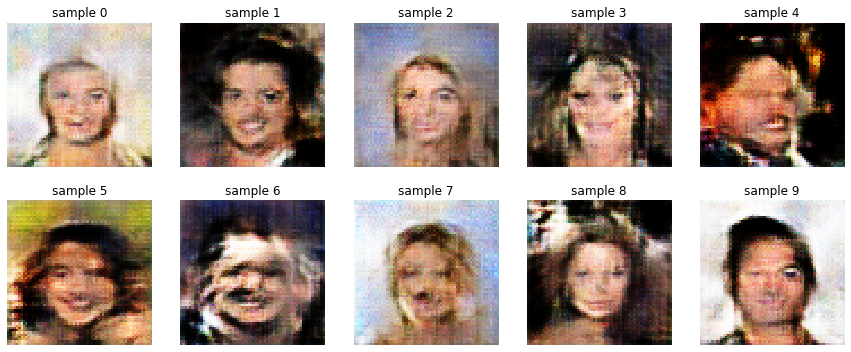

In [16]:
visualize_samples(samples)

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

In [17]:
z1 = np.random.uniform(-1, 1, [Z_DIM]).astype(np.float32)
z2 = np.random.uniform(-1, 1, [Z_DIM]).astype(np.float32)

batchz = []
alpha_list = np.linspace(0,1,BATCH_SIZE)
for alpha in alpha_list:
    batchz.append(z1*alpha + (1-alpha)*z2)
    
batchz = np.array(batchz).astype(np.float32)
with tf.Session() as sess:
    load(sess, 'checkpoint')
    samples = sess.run(G, feed_dict={z: batchz, is_training: False})


INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


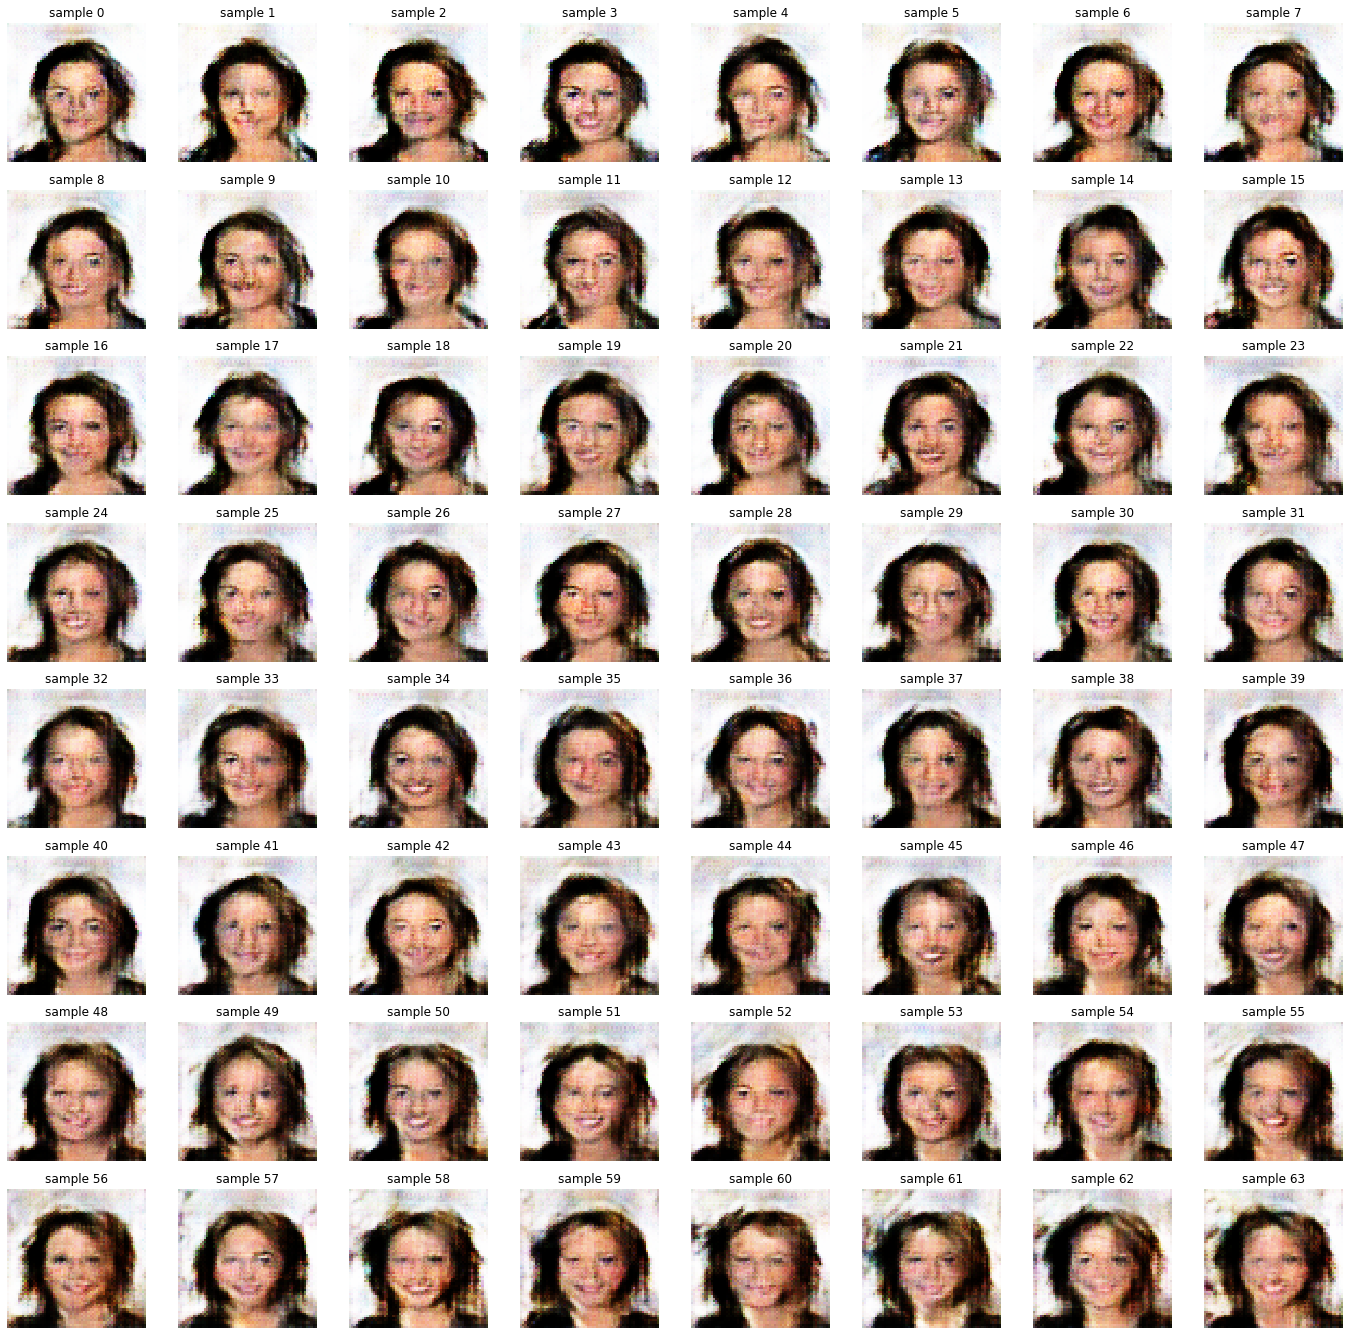

In [18]:
visualize_samples(samples, 8, 8)

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

In [19]:
batchz = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
with tf.Session() as sess:
    load(sess, 'checkpoint')
    samples = sess.run(G, feed_dict={z: batchz, is_training: False})


INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


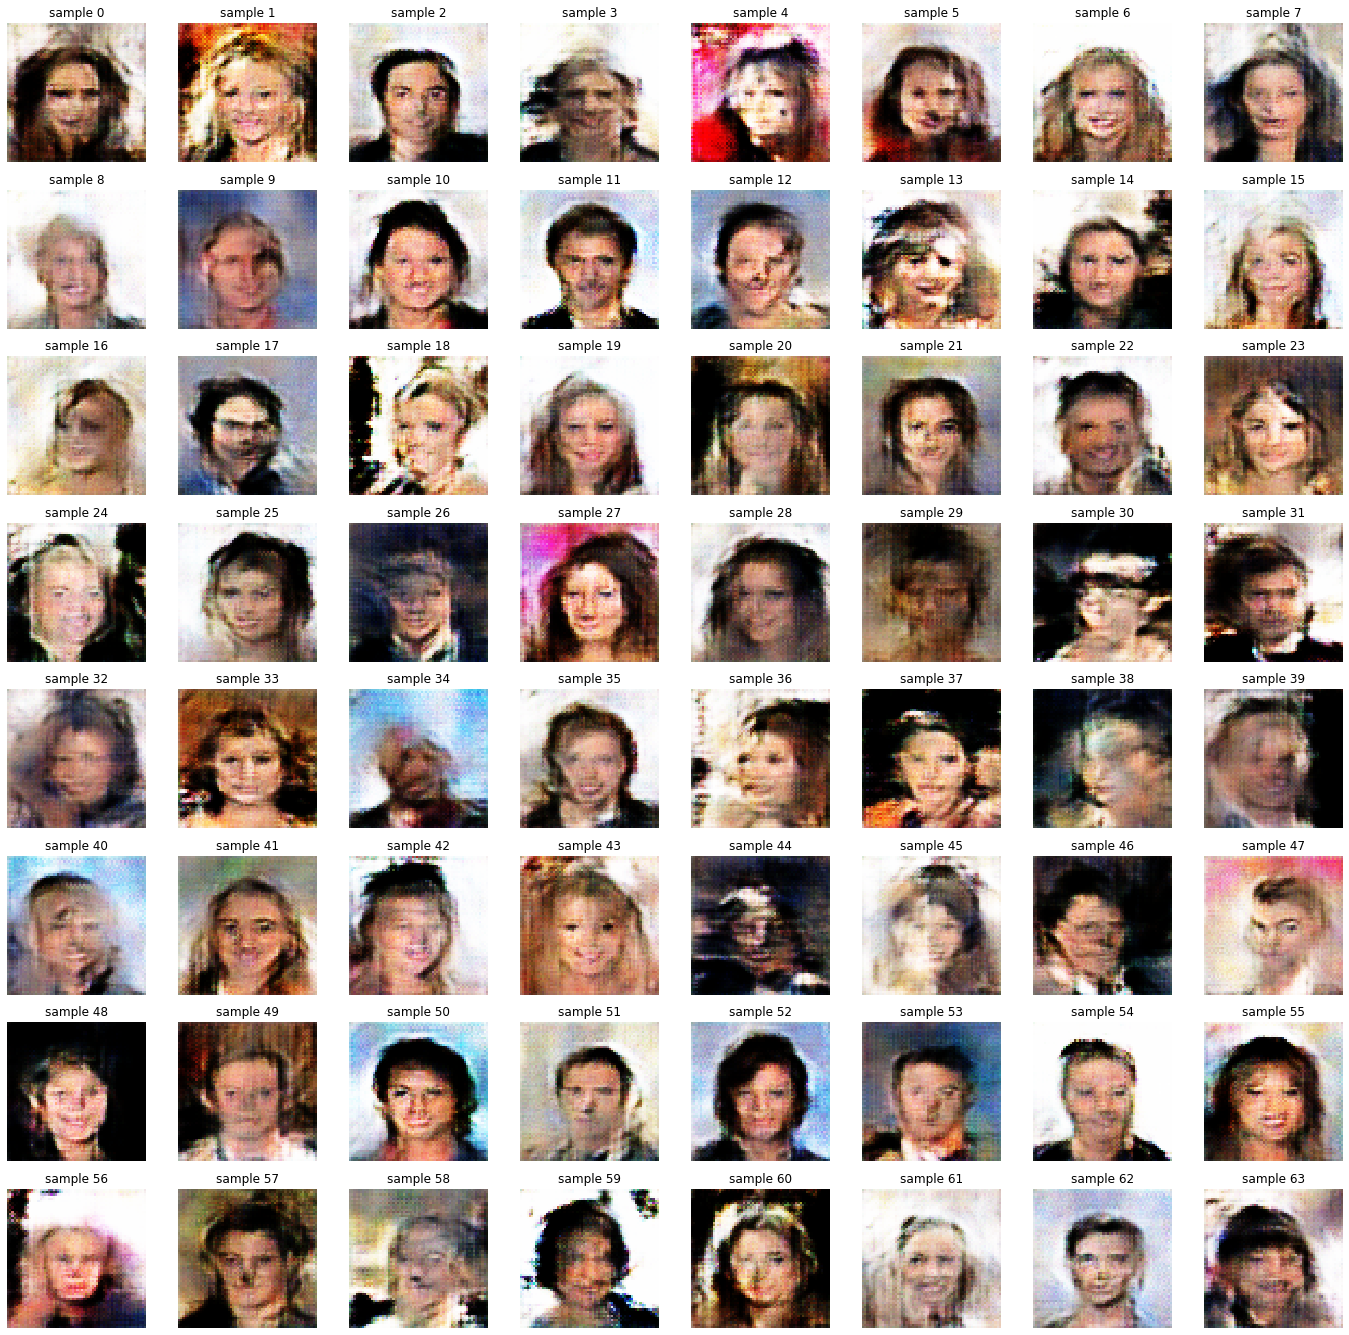

In [20]:
visualize_samples(samples, 8, 8)

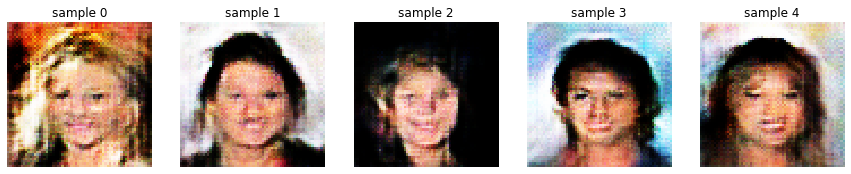

In [22]:
# selected smile faces
smile_yes = [1,10,48, 50,55]
visualize_samples(samples[smile_yes],5,1)

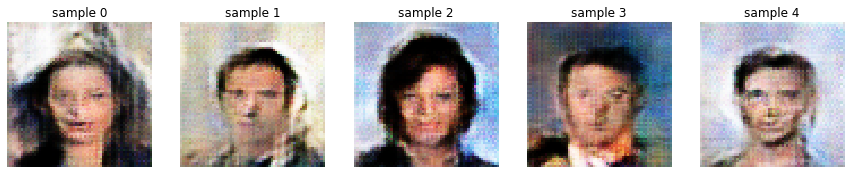

In [24]:
# selected no smile faces
smile_no = [7, 51,52,53,62]
visualize_samples(samples[smile_no],5,1)

INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


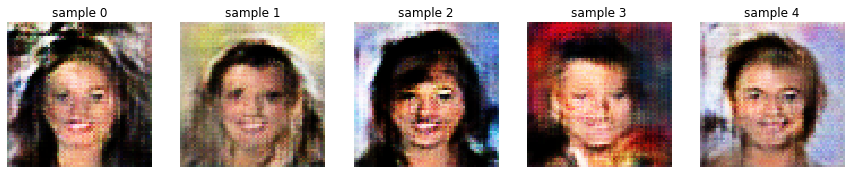

In [25]:
# Add smile vector
smile_vector = batchz[smile_yes].mean(axis=0)-batchz[smile_no].mean(axis=0) 
new_batchz = batchz + smile_vector
with tf.Session() as sess:
    load(sess, 'checkpoint')
    new_samples = sess.run(G, feed_dict={z: new_batchz, is_training: False})

visualize_samples(new_samples[smile_no],5,1)

If faces looks really cool, add bonus 1 point to your score.